## Data cleaning

### Set up

We first import the different libraries that we will be using for this project

In [ ]:
import pandas as pd
from datetime import datetime 
from unidecode import unidecode


We import our dataset

In [ ]:
data_path="data/fires-weather.csv"
try:
    weather_fires=pd.read_csv(data_path)
except Exception as error:
    print(f"Error while importing the excel file: {error}")
weather_fires.head()

### Split train and test data

In [ ]:
# Dividir los datos en train y test
df_train = weather_fires[weather_fires['Anno'] <= 2015].reset_index(drop=True) #Modificados
df_test = weather_fires[weather_fires['Anno'] >= 2016].reset_index(drop=True)

df_train = pd.DataFrame(df_train)
df_test = pd.DataFrame(df_test)


# Calcular tamaños de train y test
train_size = len(df_train)
test_size = len(df_test)
total_size = len(weather_fires)

# Calcular porcentajes
train_percentage = (train_size / total_size) * 100
test_percentage = (test_size / total_size) * 100

# Mostrar resultados
print(f"\nTamaño total: {total_size}")
print(f"Train: {train_size} filas ({train_percentage:.2f}%)")
print(f"Test: {test_size} filas ({test_percentage:.2f}%)")

# Verificar los resultados
print("Train:")
print(df_train.head(), "\n--------------\n", df_train.tail())
print("\nTest:")
print(df_test.head(), "\n--------------\n", df_test.tail()) # No se usará hasta el final

x_train = df_train.drop(columns=['superficie', 'numero_incendios'])
y_train = df_train['superficie']

x_test = df_test.drop(columns=['superficie', 'numero_incendios'])
y_test = df_test['superficie']

x_train.head()

## Train models

In [ ]:

!pip install scikit-learn

### Analyze train data set

In [ ]:

from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold, TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn import metrics

x_train = x_train.dropna()
y_train = y_train[x_train.index]

x_test = x_test.dropna()
y_test = y_test[x_test.index]
# Data split
inner_cv = TimeSeriesSplit(n_splits=7)

In [ ]:
import time
knn_pipe = Pipeline([
    ('scaler', MinMaxScaler()),
    ('knn', KNeighborsRegressor())]
)

# KNN con ajuste de hiperparámetros ---------------------------------------
param_grid = {
    'knn__n_neighbors': [3,5,7,11,15,19,23,25],
    'knn__weights': ['uniform', 'distance'],
    'knn__metric': ['minkowski', 'euclidean', 'manhattan'] 
}

knn_hpo = GridSearchCV(knn_pipe, param_grid, scoring='neg_mean_absolute_error', cv=inner_cv, n_jobs=-1, verbose=1)
knn_hpo.fit(x_train, y_train)



print(f"Mejor puntuación MAE: ", -knn_hpo.best_score_)
print("Mejores hiperparámetros:", knn_hpo.best_params_)

In [ ]:
import matplotlib.pyplot as plt
# Escalar los datos de prueba

# Predecir usando el mejor modelo encontrado
y_pred = knn_hpo.best_estimator_.predict(x_test)

# Graficar valores reales vs. predichos
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Valores Reales', marker='o')
plt.plot(y_pred, label='Valores Predichos', marker='x')
plt.title('Comparación de Valores Reales vs. Predichos')
plt.xlabel('Índice')
plt.ylabel('Valor')
plt.legend()
plt.grid()
plt.show()

from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_test, y_pred)

# Mostrar el MAE
print(f"Error Absoluto Medio (MAE) test: {mae}")

In [ ]:
from sklearn.tree import DecisionTreeRegressor

tree_pipe = Pipeline([
    ('tree', DecisionTreeRegressor(random_state=100472313))
])

#Árboles de regresión con HPO -----------------------------

param_grid = {
    'tree__criterion':['squared_error', 'friedman_mse', 'absolute_error'],
    'tree__max_depth': [5,7,9,11],
    'tree__min_samples_split': [40 ,50, 70, 90, 110, 130, 150],
}


tree_hpo = GridSearchCV(tree_pipe, param_grid, scoring='neg_mean_absolute_error', cv=inner_cv, n_jobs=-1, verbose=1)
tree_hpo.fit(x_train, y_train)


print(f"Mejor puntuación MAE: ", -tree_hpo.best_score_)
print("Mejores hiperparámetros:", tree_hpo.best_params_)


In [ ]:
y_pred = tree_hpo.best_estimator_.predict(x_test)

# Graficar valores reales vs. predichos
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Valores Reales', marker='o', linestyle='-', linewidth=2)
plt.plot(y_pred, label='Valores Predichos', marker='x', linestyle='--', linewidth=2)
plt.title('Comparación de Valores Reales vs. Predichos (Árbol de Decisión)')
plt.xlabel('Índice')
plt.ylabel('Valor')
plt.legend()
plt.grid(True)
plt.show()

mae = mean_absolute_error(y_test, y_pred)

# Mostrar el MAE
print(f"Error Absoluto Medio (MAE) test: {mae}")

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, cross_val_score
import time

# Define the Random Forest pipeline
rf_pipe = Pipeline([
    ('rf', RandomForestRegressor(random_state=100472313))
])

# Random Forest Regression with Hyperparameter Optimization (HPO)
param_grid = {
    'rf__n_estimators': [50, 100, 150, 200],  # Number of trees
    'rf__max_depth': [5, 10, 15, 20, None],  # Maximum depth of trees
    'rf__min_samples_split': [2, 5, 10],  # Minimum samples required to split a node
    'rf__min_samples_leaf': [1, 2, 4],  # Minimum samples required at each leaf
    'rf__max_features': ['sqrt', 'log2']  # Number of features considered for splitting
}


rf_hpo = GridSearchCV(rf_pipe, param_grid, scoring='neg_mean_absolute_error', cv=inner_cv, n_jobs=-1, verbose=1)
rf_hpo.fit(x_train, y_train)


print(f"Best MAE score: {-rf_hpo.best_score_:.2f}")
print("Best hyperparameters:", rf_hpo.best_params_)


In [ ]:
# Predict using the best model found during HPO
y_pred_rf = rf_hpo.best_estimator_.predict(x_test)

# Calculate MAE for Random Forest
mae_rf = mean_absolute_error(y_test, y_pred_rf)

# Print the MAE
print(f"Random Forest - Error Absoluto Medio (MAE): {mae_rf:.2f}")

# Plot real vs predicted values for Random Forest
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Valores Reales', marker='o', linestyle='-', alpha=0.8)
plt.plot(y_pred_rf, label='Valores Predichos (Random Forest)', marker='x', linestyle='--', alpha=0.8)
plt.title('Random Forest: Comparación de Valores Reales vs. Predichos')
plt.xlabel('Índice')
plt.ylabel('Valor')
plt.legend()
plt.grid()
plt.show()

In [ ]:
from sklearn.svm import SVR

svm_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVR())
])

#SVM hpo -------------------

param_grid = {
    'svm__kernel': ['rbf', 'poly'],
    'svm__C': [1, 100, 1000, 1100],
    'svm__degree': [1, 2, 3],
    'svm__gamma': ['scale' , 0.001, 0.1]
}


svm_hpo = GridSearchCV(svm_pipe, param_grid, scoring='neg_mean_absolute_error', cv=inner_cv, n_jobs=-1, verbose=1)
svm_hpo.fit(x_train, y_train)


print(f"Mejor puntuación MAE: ", -svm_hpo.best_score_)
print("Mejores hiperparámetros:", svm_hpo.best_params_)

In [ ]:
# Predict using the best model found during HPO
y_pred_svm = svm_hpo.best_estimator_.predict(x_test)

# Calculate MAE for SVM
mae_svm = mean_absolute_error(y_test, y_pred_svm)

# Print the MAE
print(f"SVM - Error Absoluto Medio (MAE): {mae_svm:.2f}")

# Plot real vs predicted values for SVM
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Valores Reales', marker='o', linestyle='-', alpha=0.8)
plt.plot(y_pred_svm, label='Valores Predichos (SVM)', marker='x', linestyle='--', alpha=0.8)
plt.title('SVM: Comparación de Valores Reales vs. Predichos')
plt.xlabel('Índice')
plt.ylabel('Valor')
plt.legend()
plt.grid()
plt.show()

In [ ]:
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, cross_val_score
import time

# Pipeline con MLPRegressor
mlp_pipe = Pipeline([
    ('mlp', MLPRegressor(random_state=100472313, max_iter=1000))
])

# Red neuronal con optimización de hiperparámetros -----------

param_grid = {
    'mlp__hidden_layer_sizes': [(50,), (100,), (100, 50), (50, 25)],  # Tamaños de las capas ocultas
    'mlp__activation': ['relu', 'tanh'],  # Función de activación
    'mlp__solver': ['adam', 'sgd'],  # Algoritmo de optimización
    'mlp__alpha': [0.0001, 0.001, 0.01],  # Tasa de regularización
    'mlp__learning_rate': ['constant', 'adaptive']  # Estrategia de tasa de aprendizaje
}

mlp_hpo = GridSearchCV(mlp_pipe, param_grid, scoring='neg_mean_absolute_error', cv=inner_cv, n_jobs=-1, verbose=1)
mlp_hpo.fit(x_train, y_train)

print(f"Mejor puntuación MAE: {-mlp_hpo.best_score_:.2f}")
print("Mejores hiperparámetros:", mlp_hpo.best_params_)


In [ ]:


y_pred_mlp = mlp_hpo.best_estimator_.predict(x_test)

# Calculate MAE for MLP
mae_mlp = mean_absolute_error(y_test, y_pred_mlp)

# Print the MAE
print(f"MLP Regressor - Error Absoluto Medio (MAE): {mae_mlp:.2f}")

# Plot real vs predicted values for MLP
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Valores Reales', marker='o', linestyle='-', alpha=0.8)
plt.plot(y_pred_mlp, label='Valores Predichos (MLP)', marker='x', linestyle='--', alpha=0.8)
plt.title('MLP Regressor: Comparación de Valores Reales vs. Predichos')
plt.xlabel('Índice')
plt.ylabel('Valor')
plt.legend()
plt.grid()
plt.show()

Fitting 3 folds for each of 108 candidates, totalling 324 fits
Mejor puntuación MAE: 260.23
Mejores hiperparámetros: {'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200, 'subsample': 0.7}
MAE en el conjunto de test final: 340.04


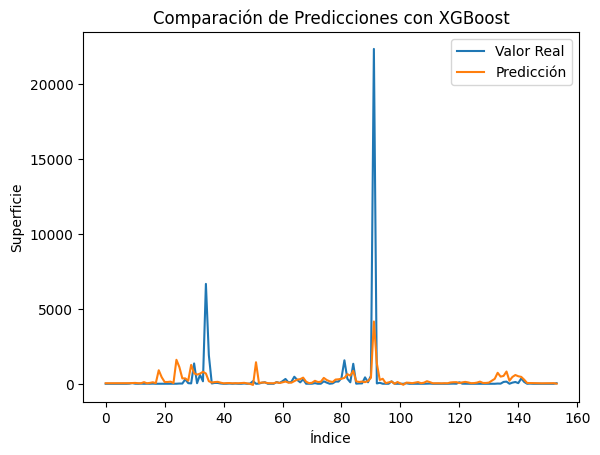

In [63]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
import time
import matplotlib.pyplot as plt

xg_reg = xgb.XGBRegressor(objective='reg:squarederror', eval_metric='mae')

# Definir el GridSearchCV para la búsqueda de hiperparámetros
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 1.0],
    'colsample_bytree': [0.7, 1.0]
}


grid_search = GridSearchCV(estimator=xg_reg, param_grid=param_grid, scoring='neg_mean_absolute_error', cv=3, verbose=1, n_jobs=-1)
grid_search.fit(x_train, y_train)


print(f"Mejor puntuación MAE: {-grid_search.best_score_:.2f}")
print("Mejores hiperparámetros:", grid_search.best_params_)

# Usar el mejor modelo encontrado para hacer predicciones
best_model = grid_search.best_estimator_

# Hacer predicciones
y_pred = best_model.predict(x_test)

# Calcular el error medio absoluto (MAE)
mae = mean_absolute_error(y_test, y_pred)
print(f"MAE en el conjunto de test final: {mae:.2f}")

# Mostrar la comparación entre las predicciones y los valores reales
plt.plot(y_test.values, label="Valor Real")
plt.plot(y_pred, label="Predicción")
plt.legend()
plt.xlabel("Índice")
plt.ylabel("Superficie")
plt.title("Comparación de Predicciones con XGBoost")
plt.show()

Mean Absolute Error (MAE): 356.50


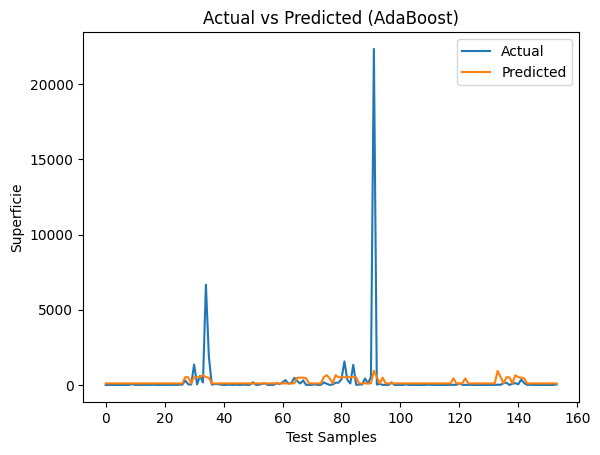

In [75]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt


# Split data for validation (optional, if you want to check cross-validation)
# For simplicity, we will use the training set and test set defined above.
# Initialize the AdaBoost Regressor with default DecisionTreeRegressor as base model
ada_boost = AdaBoostRegressor(n_estimators=50, learning_rate=1.0)

# Train the AdaBoost model
ada_boost.fit(x_train, y_train)

# Predict on the test set
y_pred = ada_boost.predict(x_test)

# Evaluate the model using Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error (MAE): {mae:.2f}')

# Plot actual vs predicted values
plt.plot(y_test.values, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.xlabel("Test Samples")
plt.ylabel("Superficie")
plt.title("Actual vs Predicted (AdaBoost)")
plt.show()

### Time series

In [ ]:
#TODO

### Con variables exogenas

In [ ]:
#TODO

## Performances

In [ ]:
#TODO

## Test Model


In [ ]:
#TODO